In [24]:
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt
from ultralytics import settings

import numpy as np
import pandas as pd
import os

from pathlib import Path
from xml.dom.minidom import parse
from shutil import copyfile

from sklearn.model_selection import train_test_split

In [25]:
classes = ['helmet','head','person']

In [26]:
def convert_annot(size , box):
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])

    dw = np.float32(1. / int(size[0]))
    dh = np.float32(1. / int(size[1]))

    w = x2 - x1
    h = y2 - y1
    x = x1 + (w / 2)
    y = y1 + (h / 2)

    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return [x, y, w, h]

In [27]:
def save_txt_file(img_jpg_file_name, size, img_box):
    save_file_name = './helmet/Dataset/labels/' +  img_jpg_file_name + '.txt'
    
    #file_path = open(save_file_name, "a+")
    with open(save_file_name ,'a+') as file_path:
        for box in img_box:

            cls_num = classes.index(box[0])

            new_box = convert_annot(size, box[1:])

            file_path.write(f"{cls_num} {new_box[0]} {new_box[1]} {new_box[2]} {new_box[3]}\n")

        file_path.flush()
        file_path.close()

In [28]:
def get_xml_data(file_path, img_xml_file):
    img_path = file_path + '/' + img_xml_file + '.xml'
    #print(img_path)

    dom = parse(img_path)
    root = dom.documentElement
    img_name = root.getElementsByTagName("filename")[0].childNodes[0].data
    img_size = root.getElementsByTagName("size")[0]
    objects = root.getElementsByTagName("object")
    img_w = img_size.getElementsByTagName("width")[0].childNodes[0].data
    img_h = img_size.getElementsByTagName("height")[0].childNodes[0].data
    img_c = img_size.getElementsByTagName("depth")[0].childNodes[0].data
   
    img_box = []
    for box in objects:
        cls_name = box.getElementsByTagName("name")[0].childNodes[0].data
        x1 = int(box.getElementsByTagName("xmin")[0].childNodes[0].data)
        y1 = int(box.getElementsByTagName("ymin")[0].childNodes[0].data)
        x2 = int(box.getElementsByTagName("xmax")[0].childNodes[0].data)
        y2 = int(box.getElementsByTagName("ymax")[0].childNodes[0].data)
        
        img_jpg_file_name = img_xml_file + '.jpg'
        img_box.append([cls_name, x1, y1, x2, y2])
  

    # test_dataset_box_feature(img_jpg_file_name, img_box)
    save_txt_file(img_xml_file, [img_w, img_h], img_box)

In [29]:
files = os.listdir('./helmet/annotations')
for file in files:
    file_xml = file.split(".")
    get_xml_data('./helmet/annotations', file_xml[0])

In [30]:
files[:5]

['hard_hat_workers0.xml',
 'hard_hat_workers1.xml',
 'hard_hat_workers10.xml',
 'hard_hat_workers100.xml',
 'hard_hat_workers1000.xml']

In [31]:
image_list = os.listdir('./helmet/images')
train_list, test_list = train_test_split(image_list, test_size=0.2, random_state=22)
val_list, test_list = train_test_split(test_list, test_size=0.5, random_state=22)
print('total =',len(image_list))
print('train :',len(train_list))
print('val   :',len(val_list))
print('test  :',len(test_list))

total = 5000
train : 4000
val   : 500
test  : 500


In [32]:
def copy_data(file_list, img_labels_root, imgs_source, mode):

    root_file = Path( './helmet/Dataset/images/'+  mode)
    if not root_file.exists():
        print(f"Path {root_file} does not exit")
        os.makedirs(root_file)

    root_file = Path('./helmet/Dataset/labels/' + mode)
    if not root_file.exists():
        print(f"Path {root_file} does not exit")
        os.makedirs(root_file)

    for file in file_list:               
        img_name = file.replace('.png', '')        
        img_src_file = imgs_source + '/' + img_name + '.png'        
        label_src_file = img_labels_root + '/' + img_name + '.txt'

        #print(img_sor_file)
        #print(label_sor_file)
        # im = Image.open(rf"{img_sor_file}")
        # im.show()

        # Copy image
        DICT_DIR = './helmet/Dataset/images/'  + mode
        img_dict_file = DICT_DIR + '/' + img_name + '.png'

        copyfile(img_src_file, img_dict_file)

        # Copy label
        DICT_DIR = './helmet/Dataset/labels/' + mode
        img_dict_file = DICT_DIR + '/' + img_name + '.txt'
        copyfile(label_src_file, img_dict_file)

In [34]:
copy_data(train_list, './helmet/Dataset/labels', './helmet/images', "train")
copy_data(val_list,   './helmet/Dataset/labels', './helmet/images', "val")
copy_data(test_list,  './helmet/Dataset/labels', './helmet/images', "test")

Path helmet\Dataset\images\val does not exit
Path helmet\Dataset\labels\val does not exit
Path helmet\Dataset\images\test does not exit
Path helmet\Dataset\labels\test does not exit


In [39]:
import yaml

# Create configuration
config = {
   "path": "./helmet/Dataset/images",
   "train": "train",
   "val": "val",
   "test": "test",
   "nc": 3,
   "names": ['helmet','head','person']
}
with open("helmet.yaml", "w") as file:
   yaml.dump(config, file, default_flow_style=False)

In [40]:
model = YOLO('yolov8n.pt') # 이미 학습되어 있는 모델

In [45]:
result = model.train(data = 'helmet.yaml', epochs = 5)

Ultralytics YOLOv8.0.194  Python-3.10.11 torch-2.0.1+cpu CPU (Intel Core(TM) i5-10210U 1.60GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=helmet.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=Fals

In [46]:
result

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000022FA7372860>
fitness: 0.4056218967770269
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.58389,     0.55166,    0.010384])
names: {0: 'helmet', 1: 'head', 2: 'person'}
plot: True
results_dict: {'metrics/precision(B)': 0.9353844136823347, 'metrics/recall(B)': 0.5724302391076584, 'metrics/mAP50(B)': 0.6184196410435762, 'metrics/mAP50-95(B)': 0.38197770296963257, 'fitness': 0.4056218967770269}
save_dir: WindowsPath('runs/detect/train9')
speed: {'preprocess': 2.8609018325805664, 'inference': 235.1256160736084, 'loss': 0.0, 'postprocess': 2.734109401702881}

In [47]:
from IPython.display import Image, clear_output
import matplotlib.pyplot as plt
%matplotlib inline

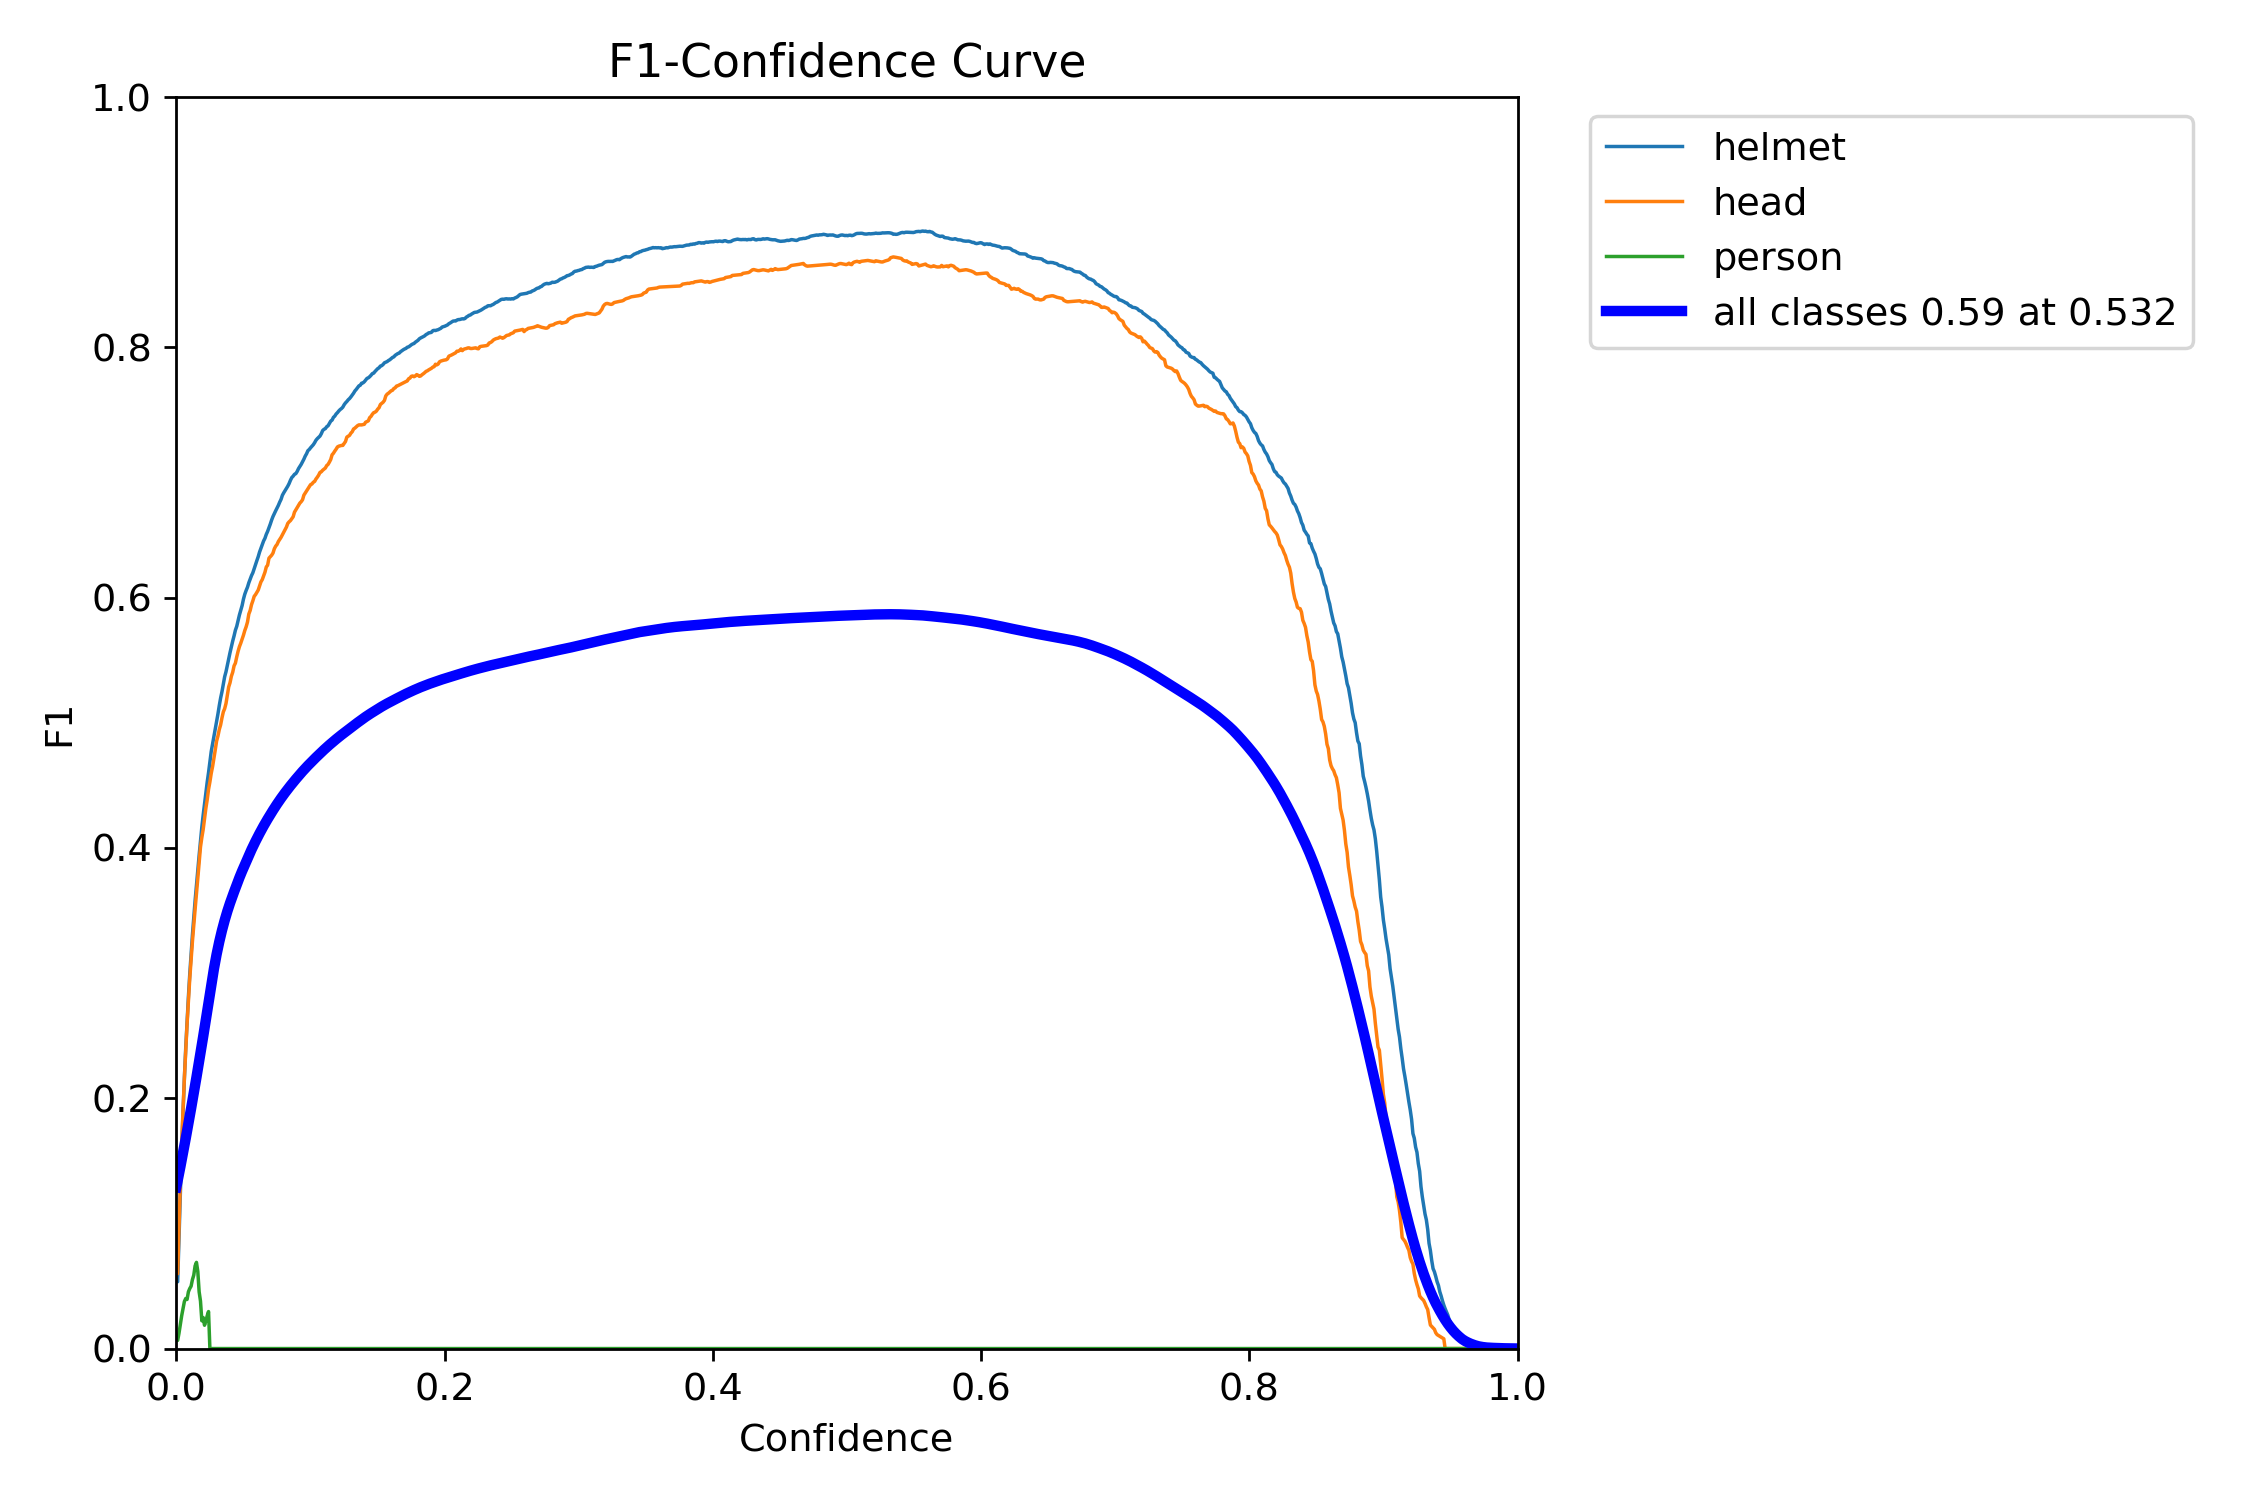

In [50]:
Image(filename='./runs/detect/train9/F1_curve.png', width=600)

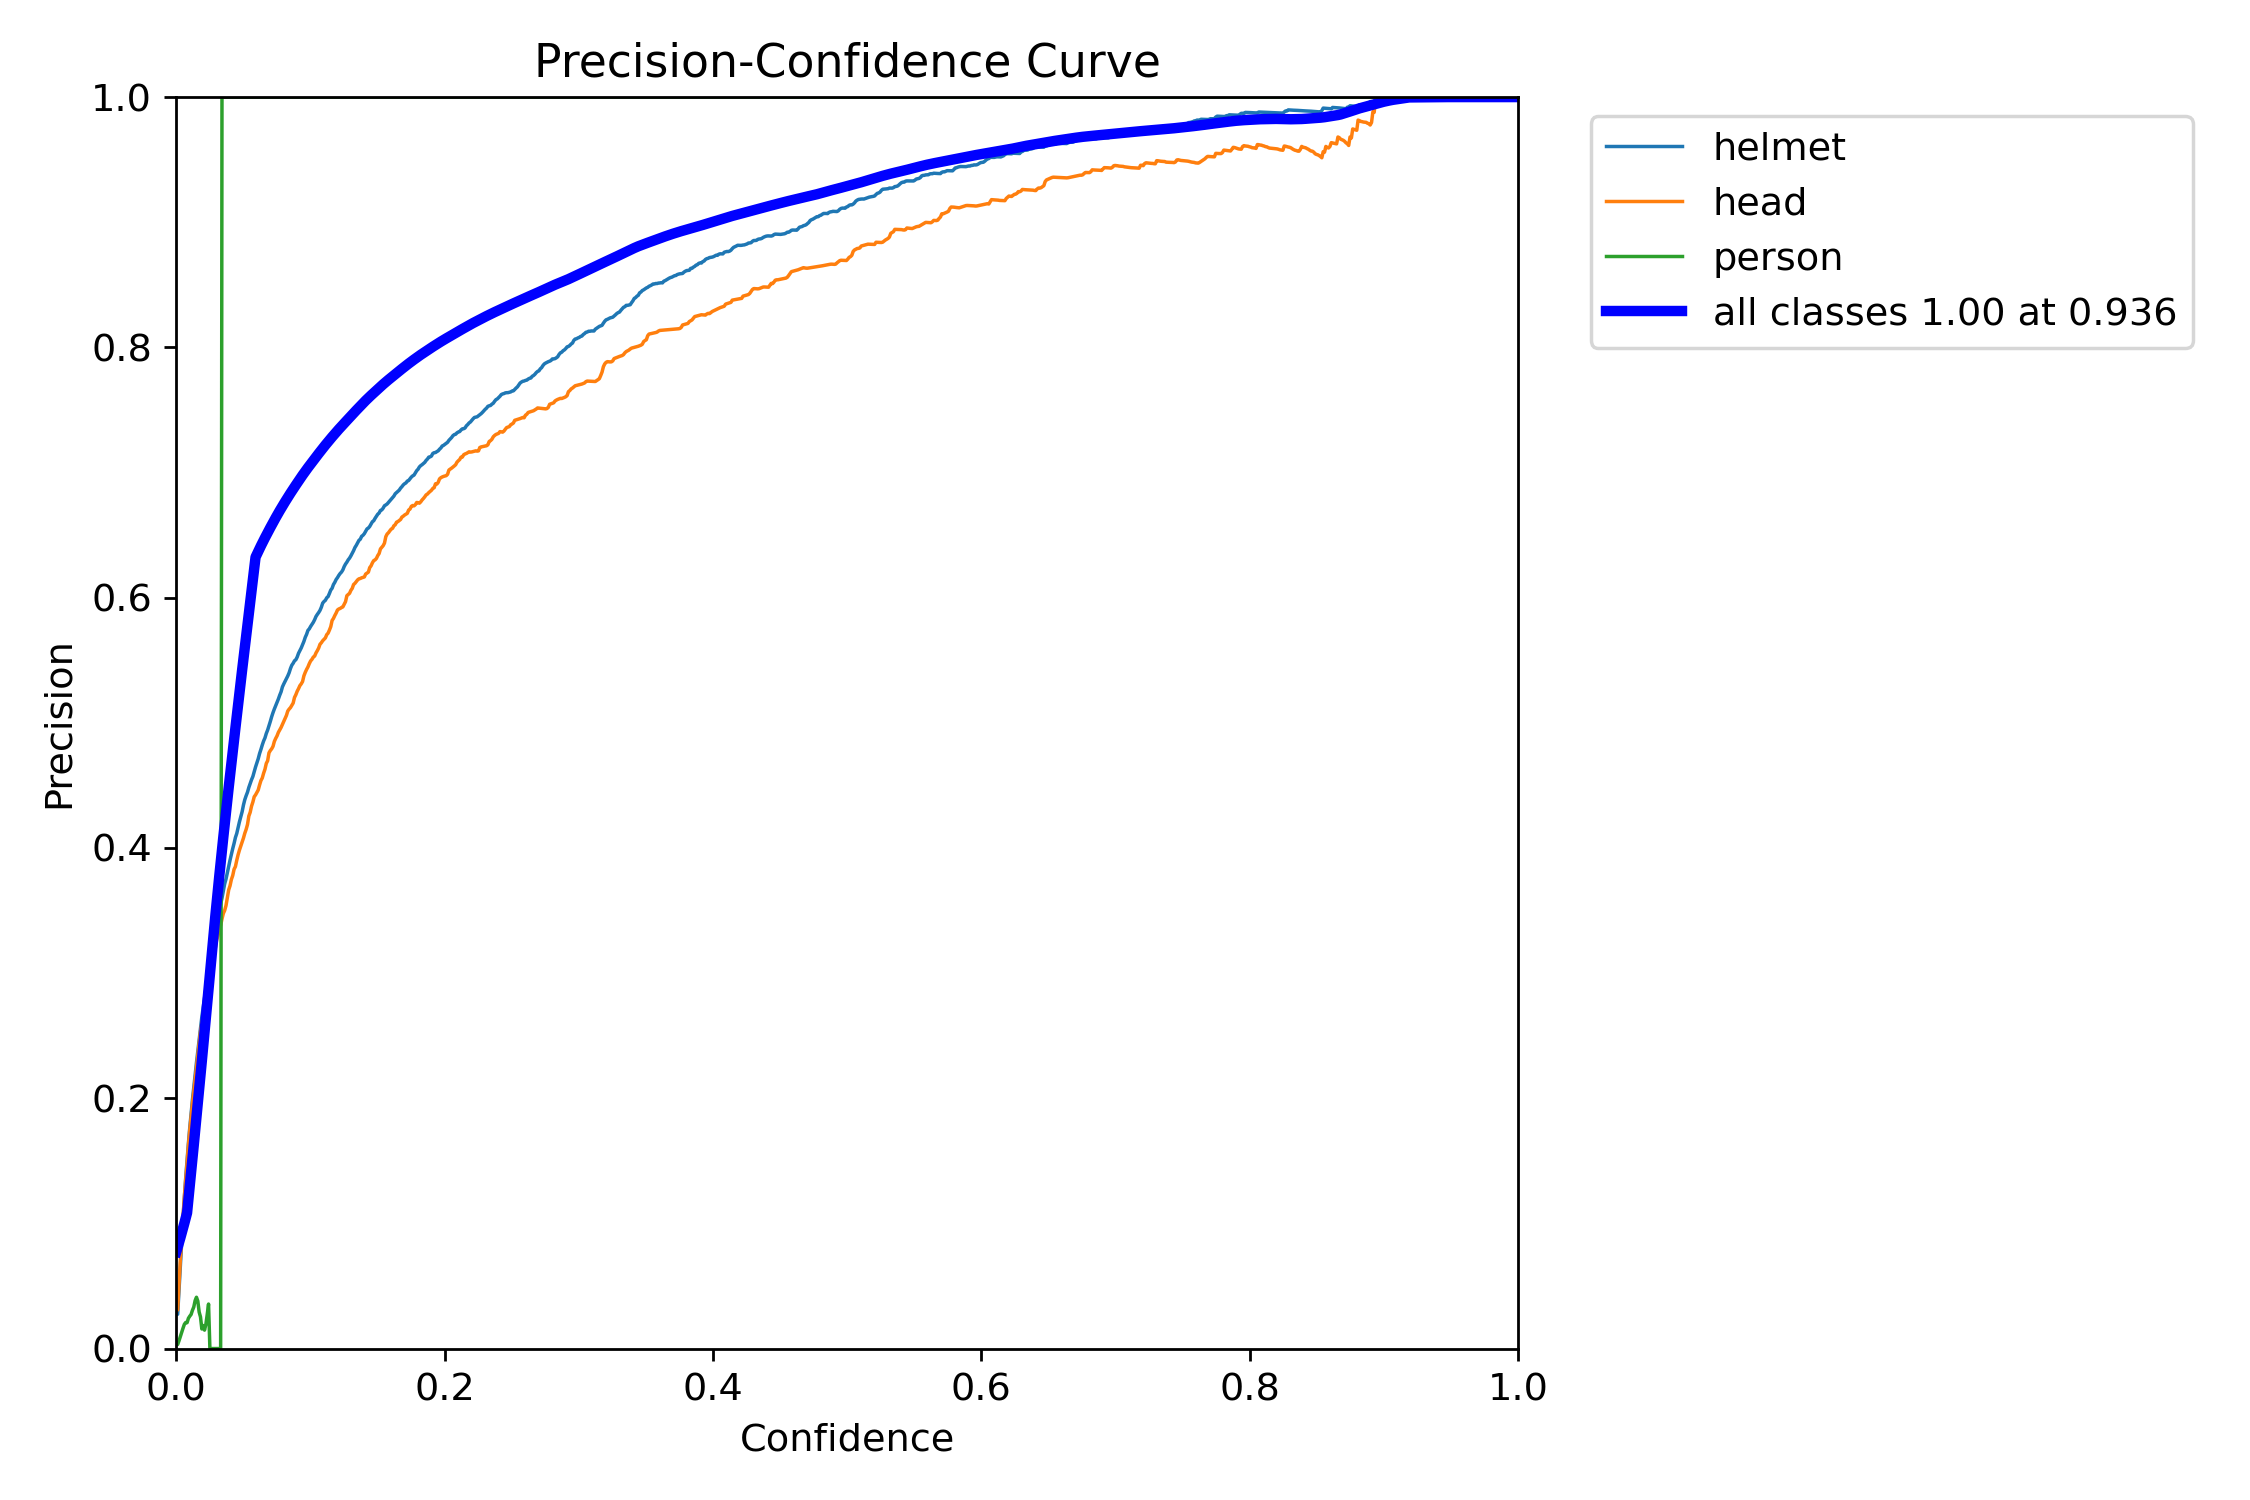

In [53]:
Image(filename='./runs/detect/train9/P_curve.png', width=600)

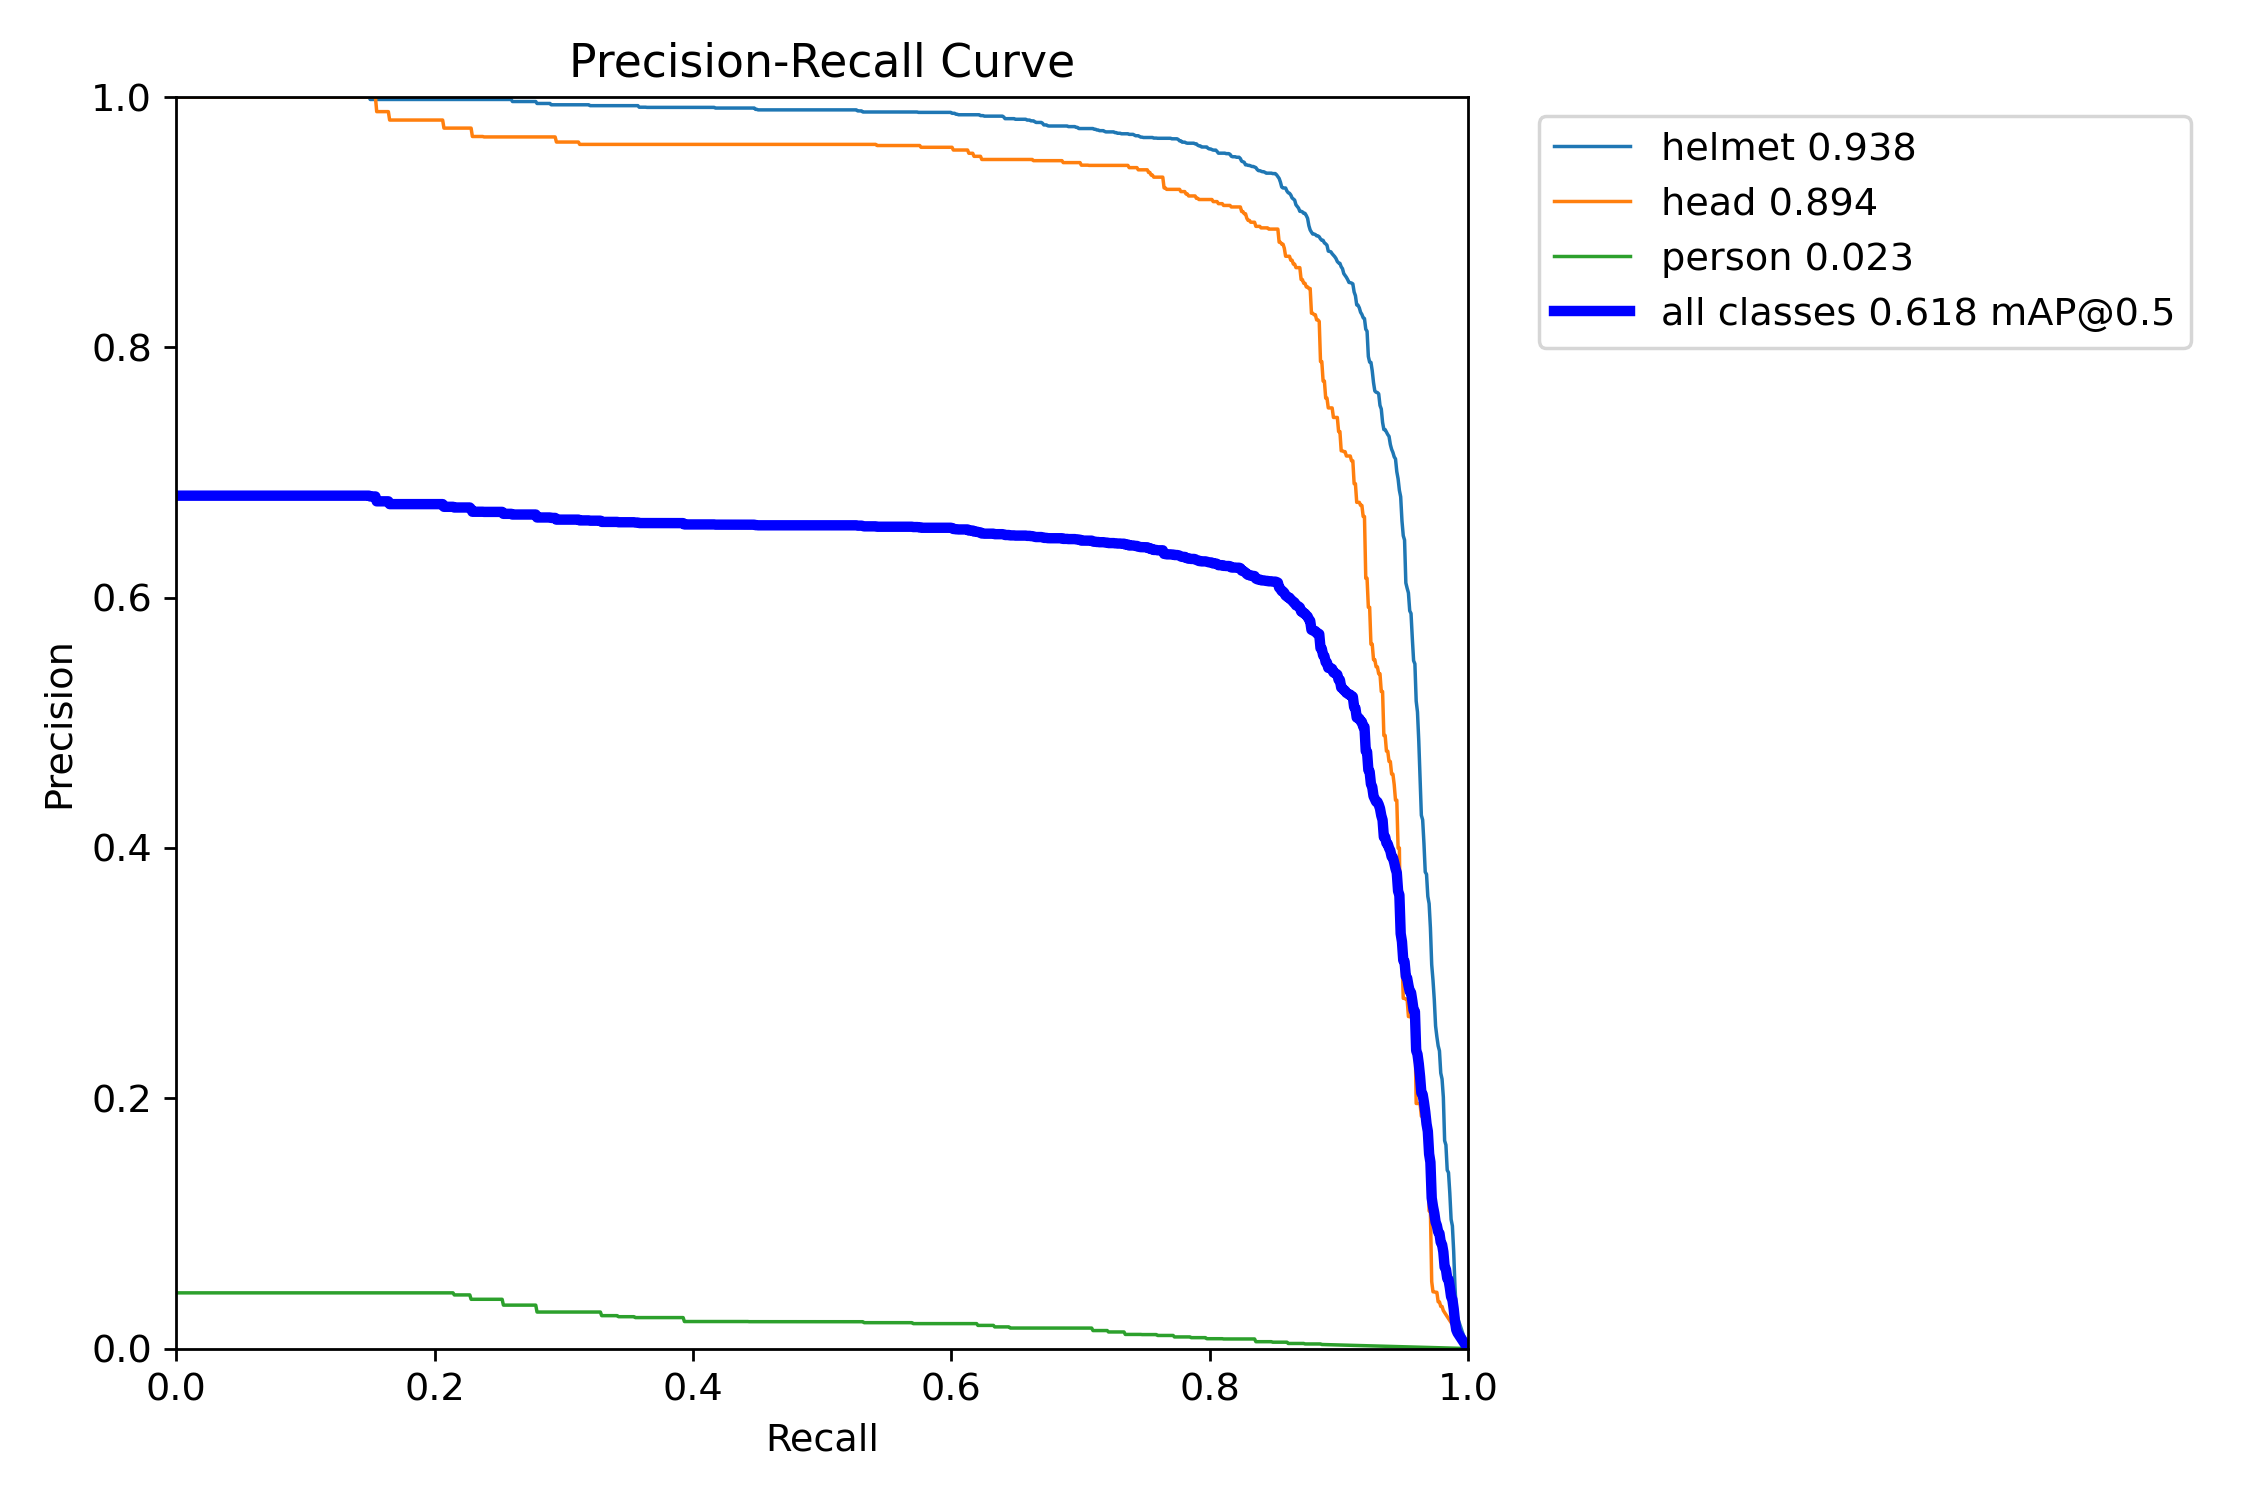

In [54]:
Image(filename='./runs/detect/train9/PR_curve.png', width=600)

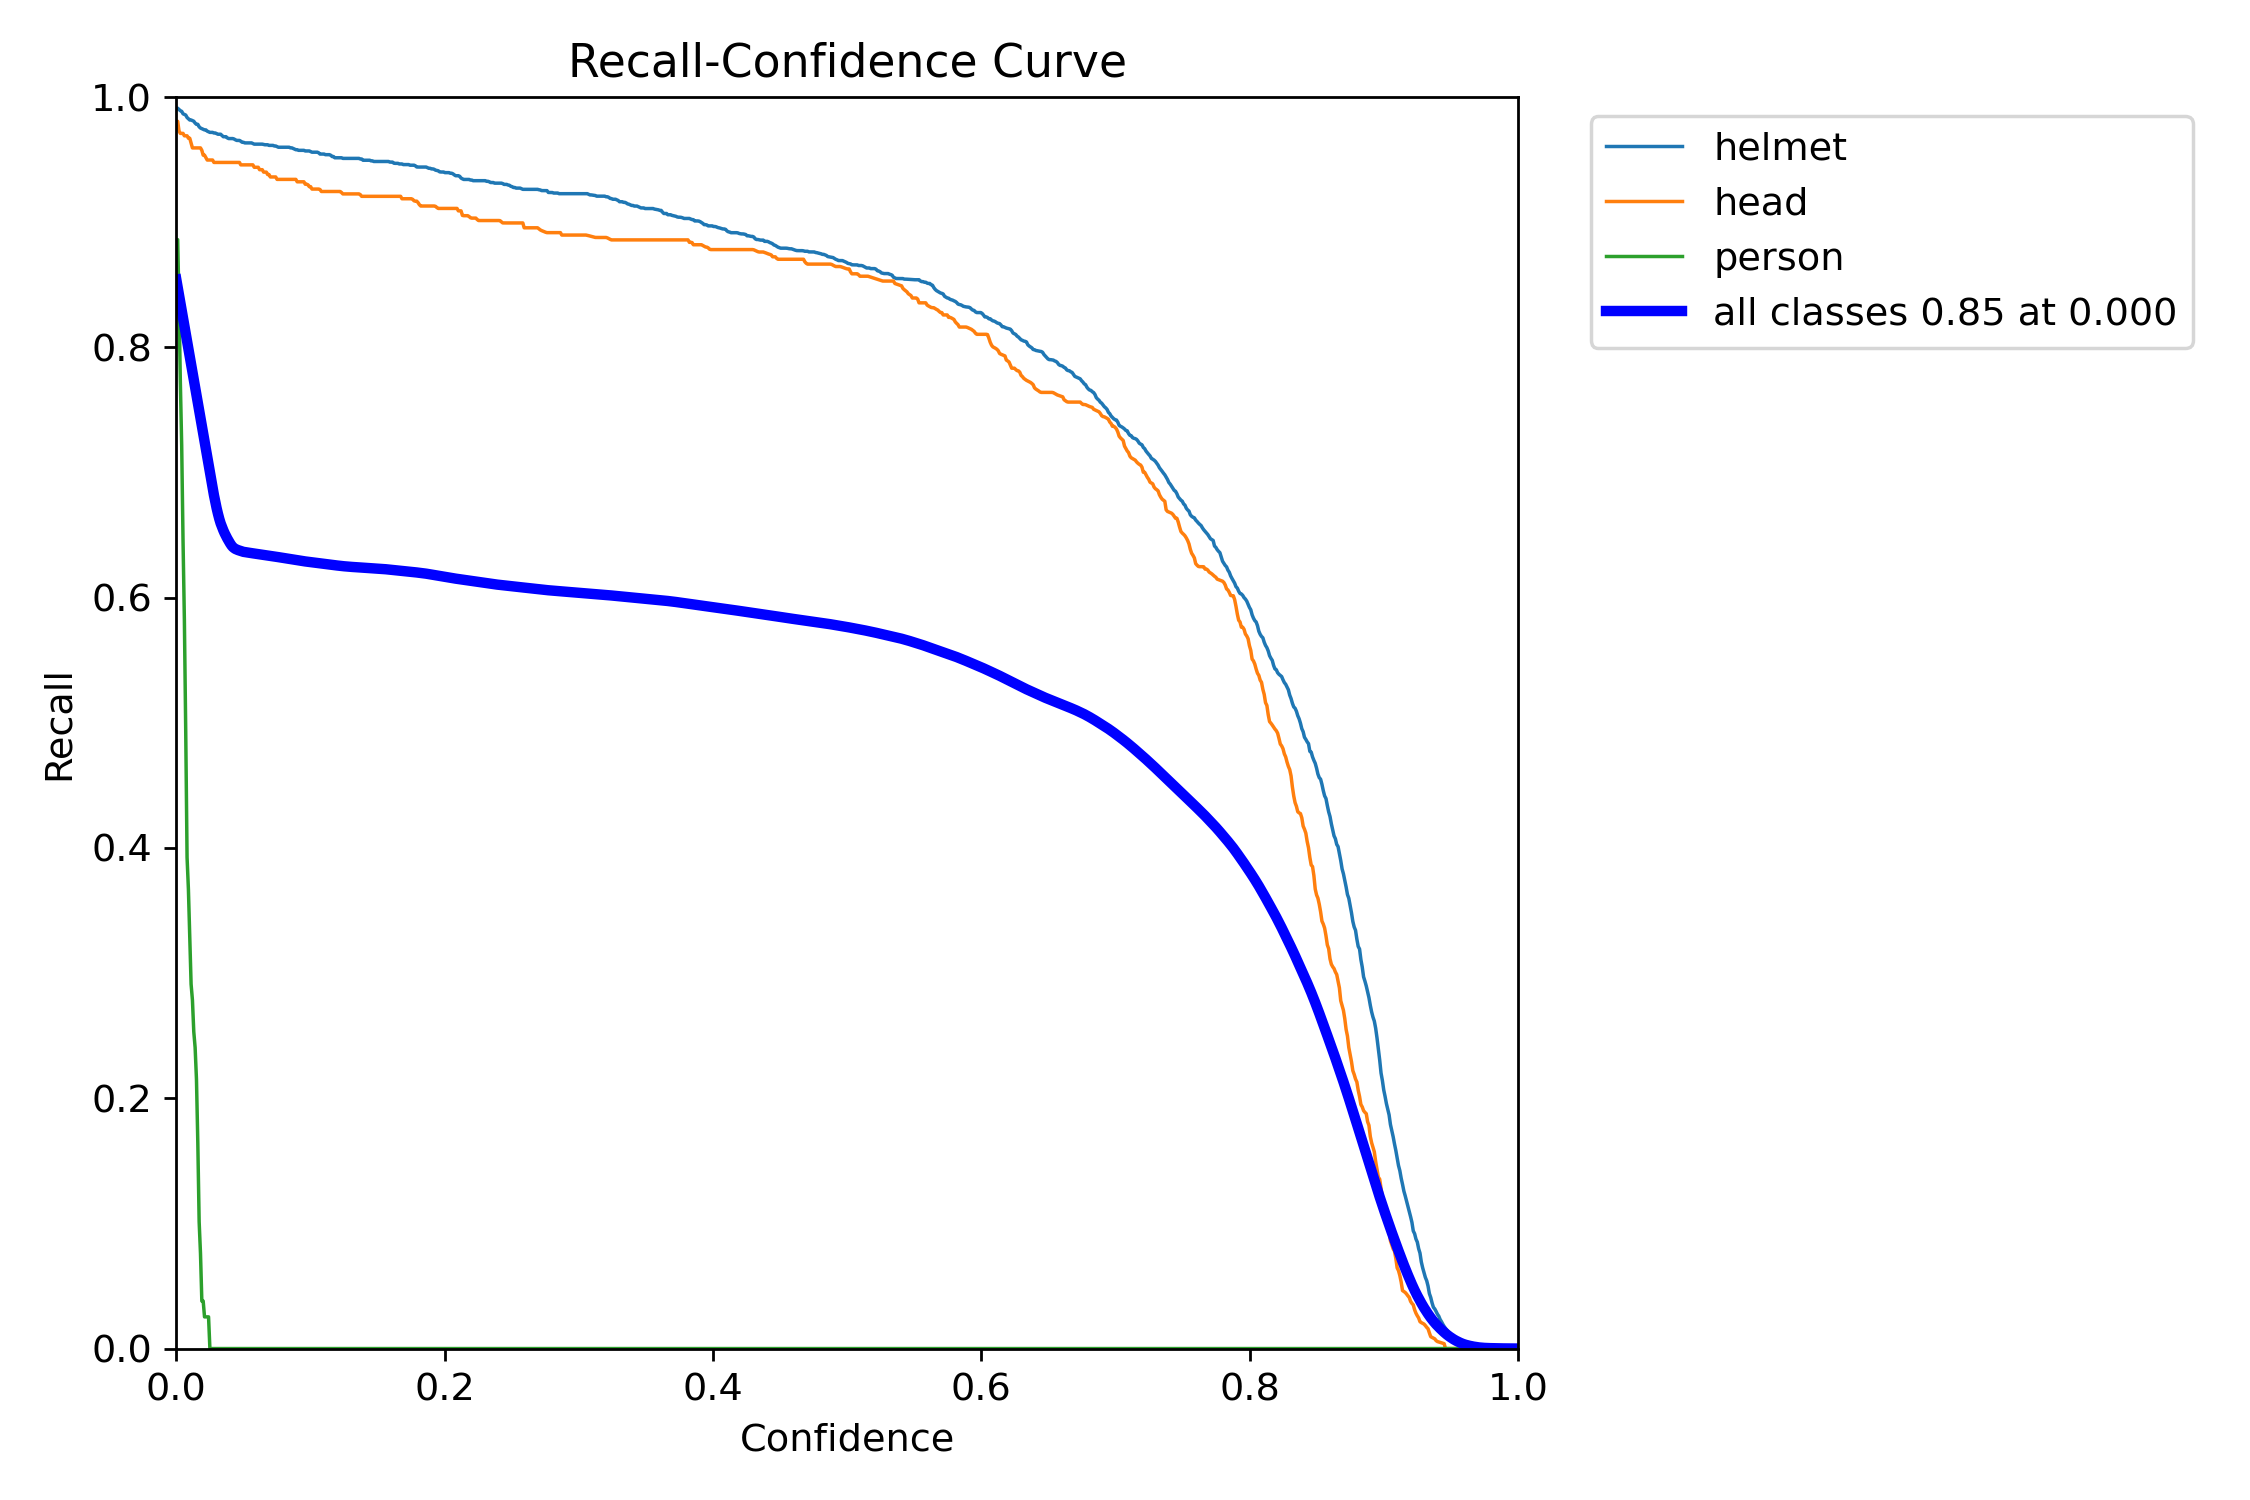

In [55]:
Image(filename='./runs/detect/train9/R_curve.png', width=600)

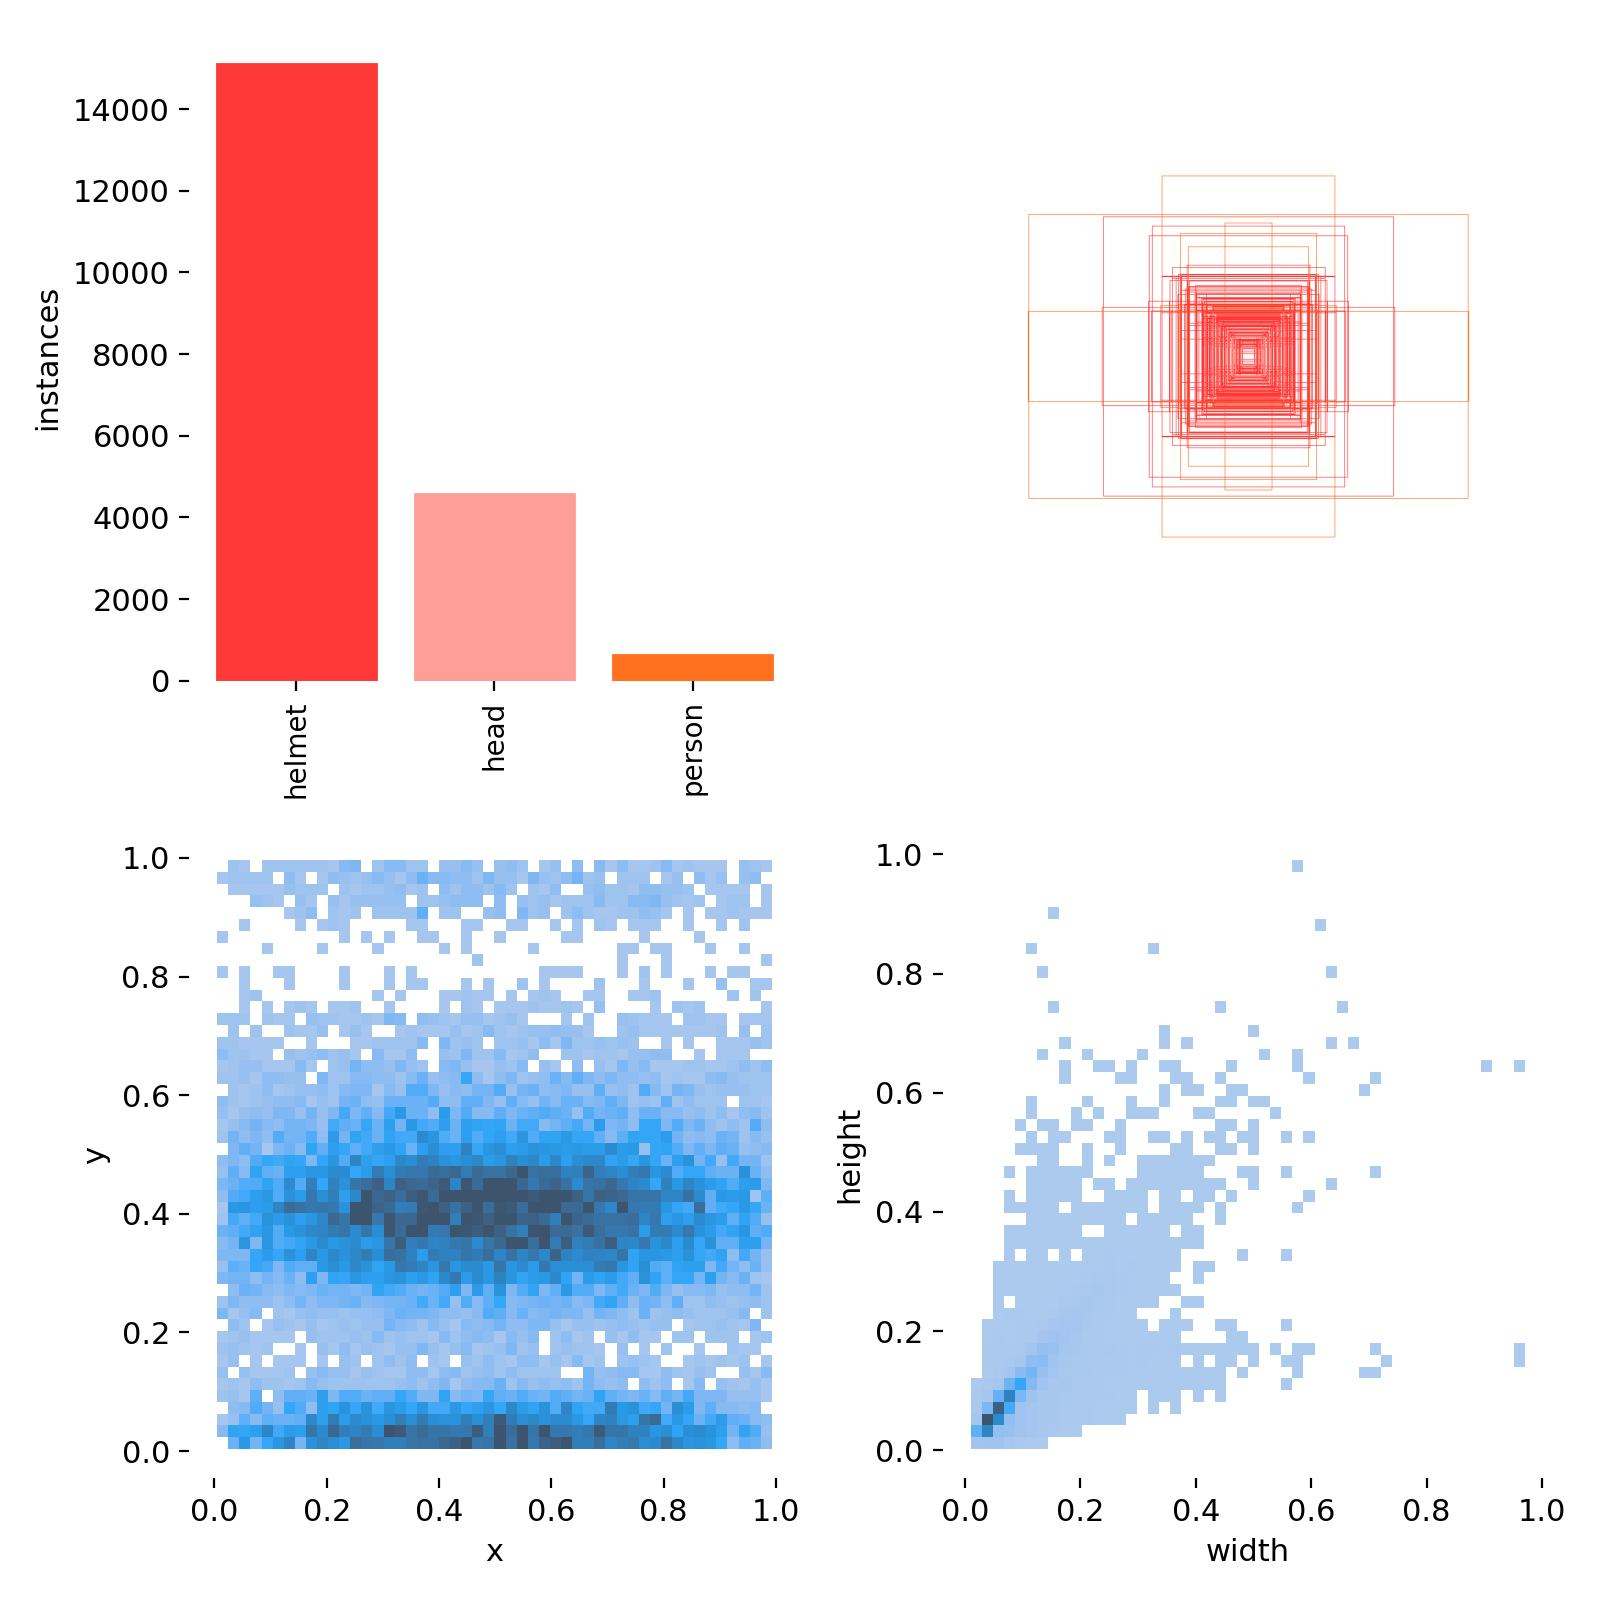

In [52]:
Image(filename='./runs/detect/train9/labels.jpg', width=600)

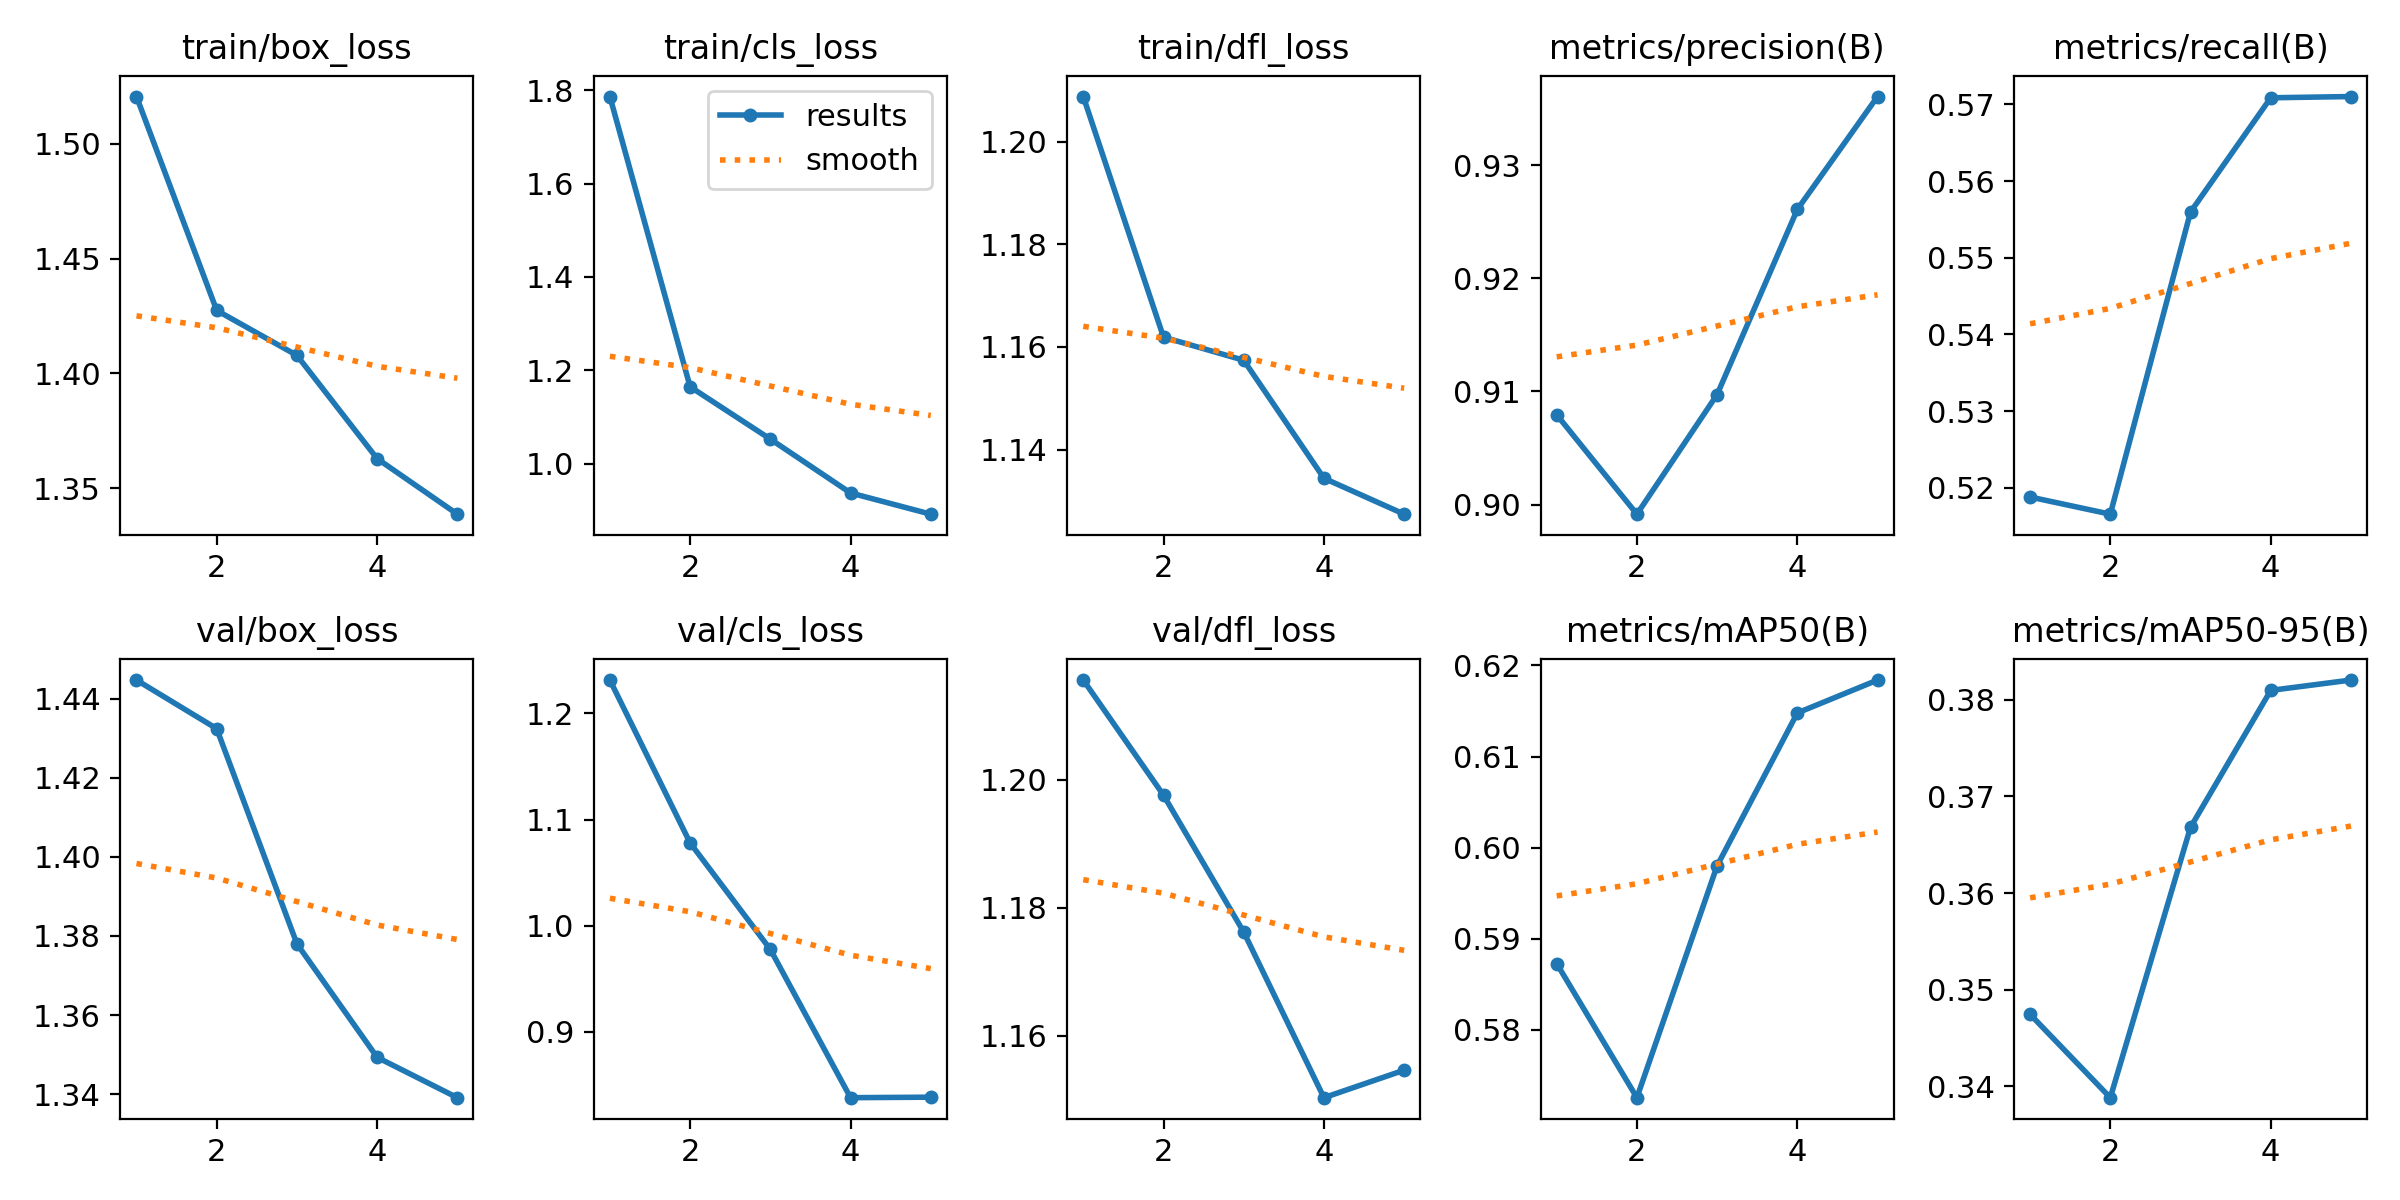

In [58]:
Image(filename='./runs/detect/train9/results.png', width=1000)

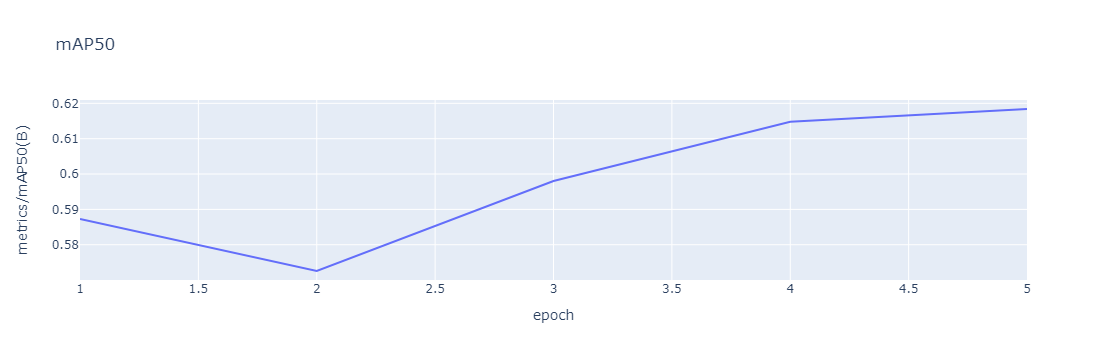

In [61]:
import plotly.express as px
import pandas as pd

df = pd.read_csv("./runs/detect/train9/results.csv")
fig = px.line(df, x='                  epoch', y='       metrics/mAP50(B)', title='mAP50')
fig.show()

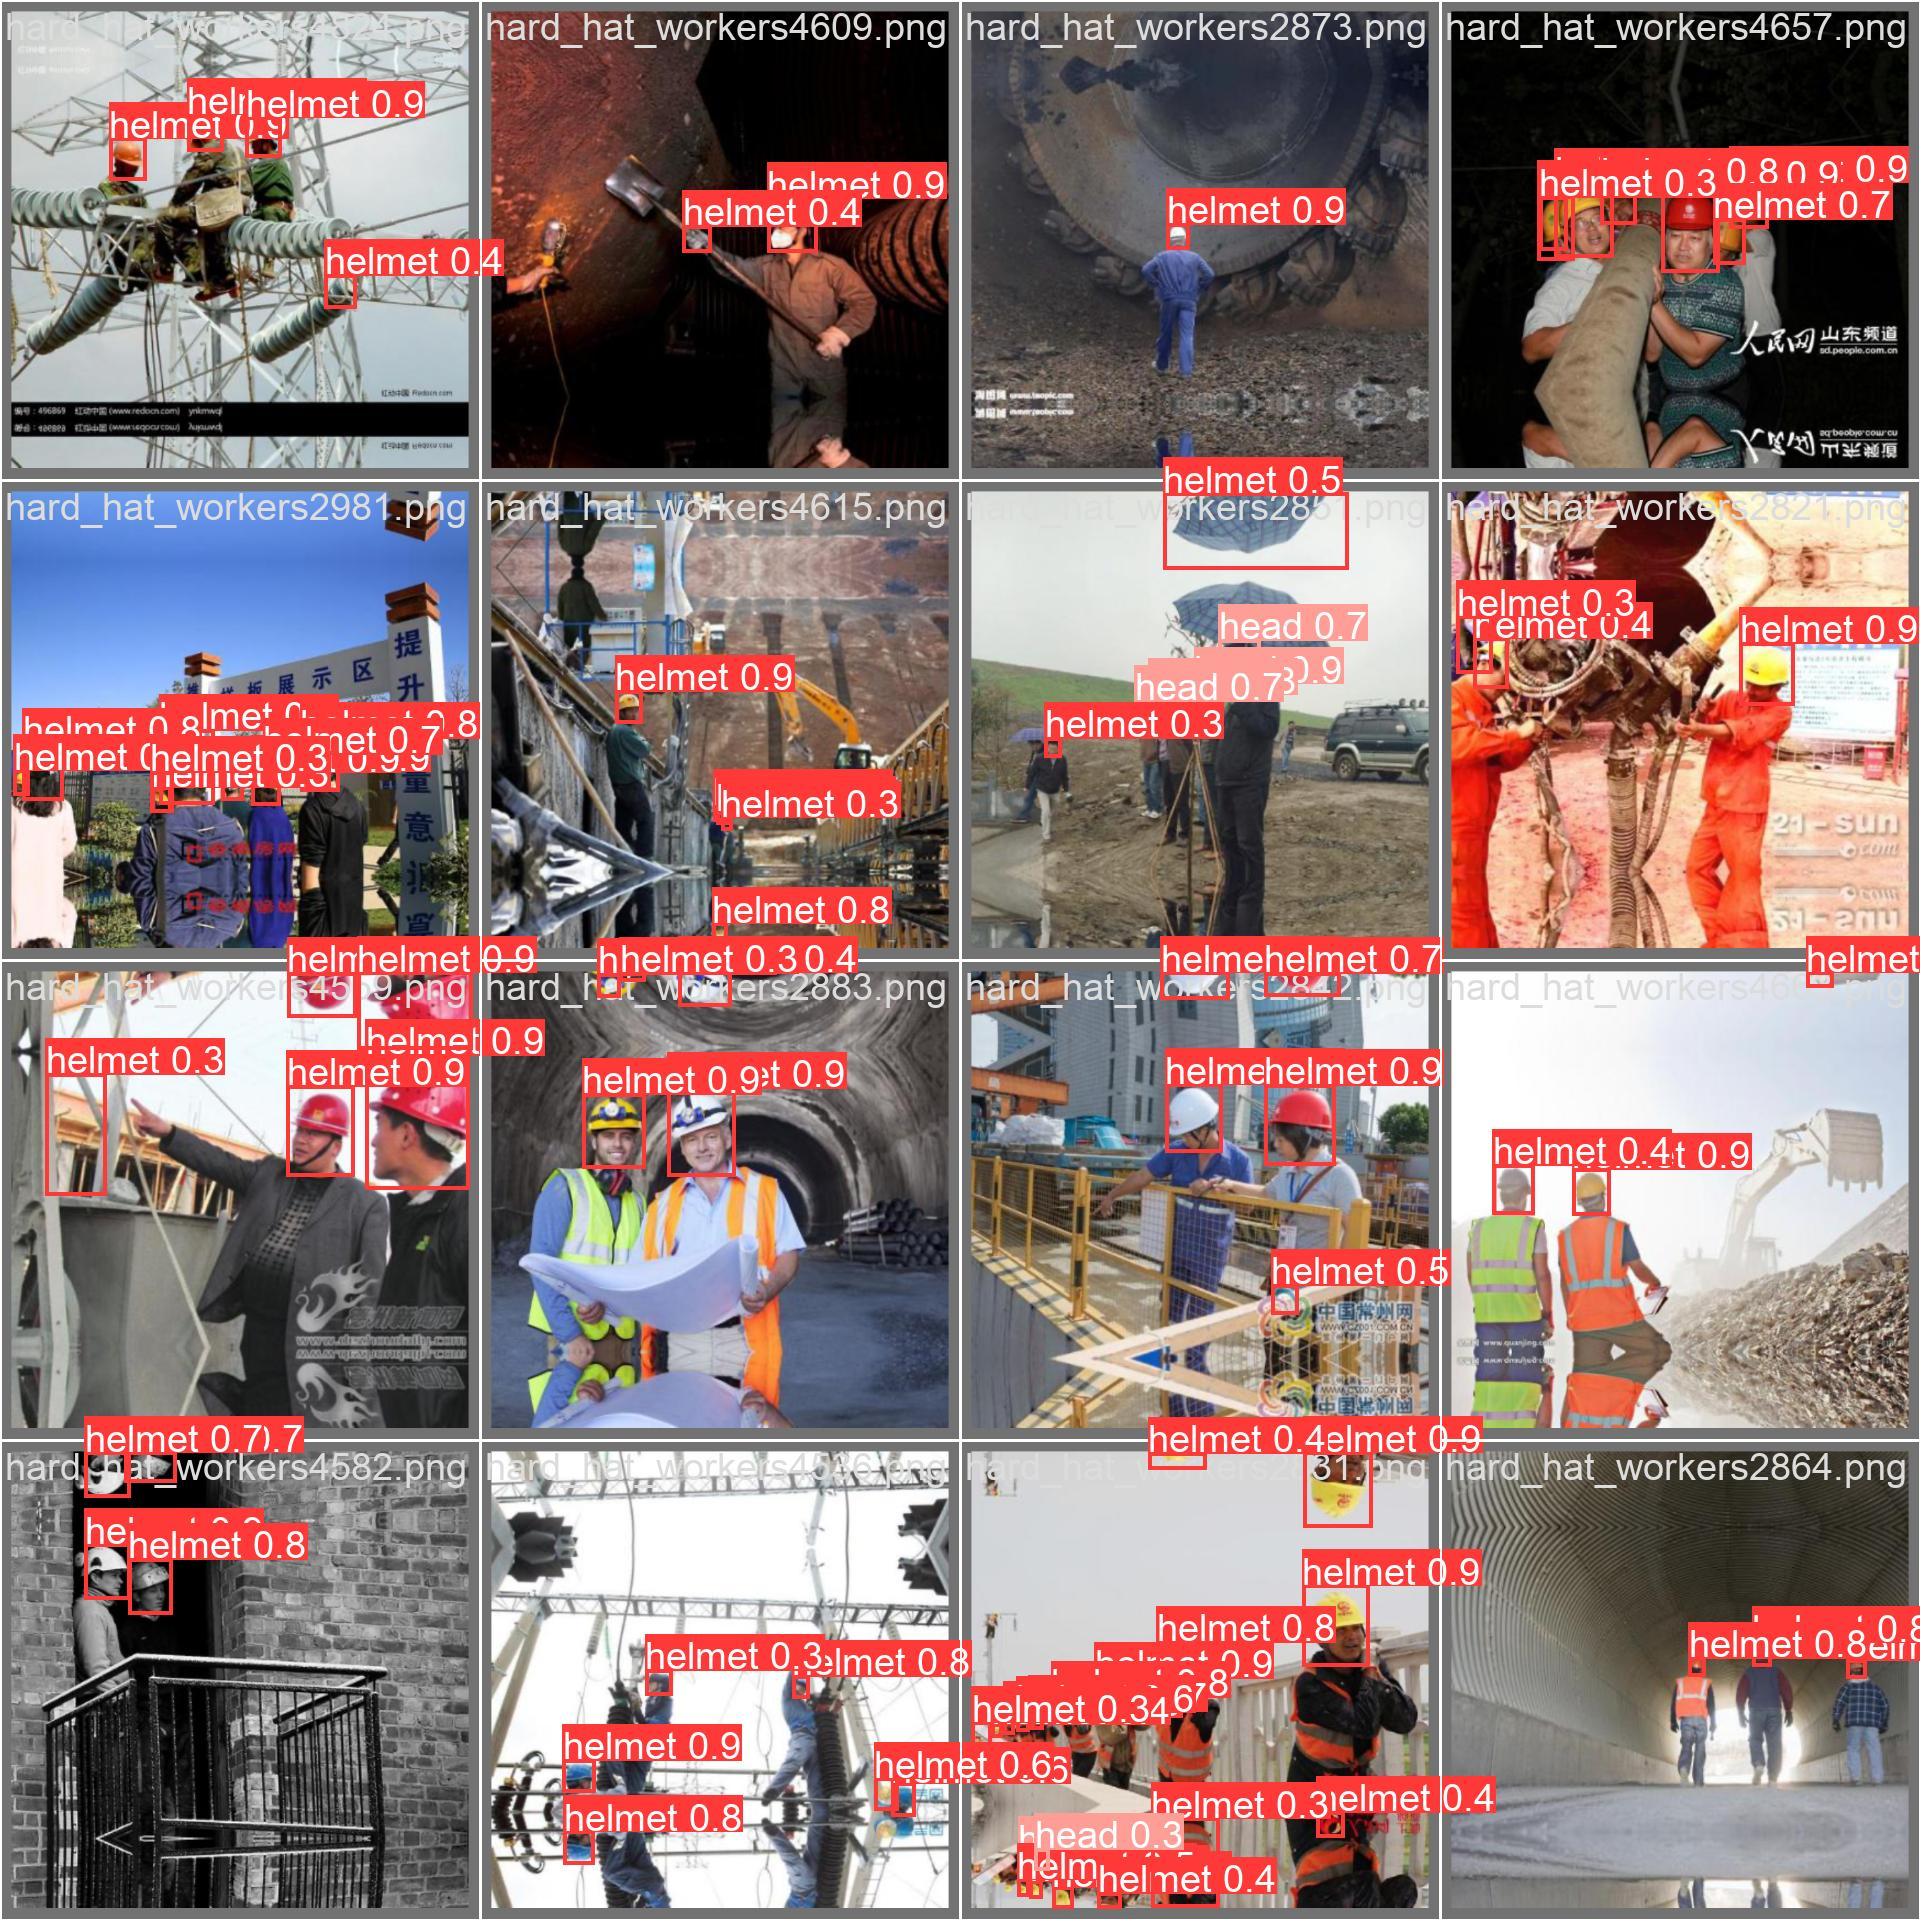

In [62]:
Image(filename='./runs/detect/train9/val_batch0_pred.jpg', width=1000)